<a href="https://colab.research.google.com/github/ZnattapolZ/Enhancing-The-Visualization-of-Latent-Fingerprint/blob/main/%5BDemo%5D%20-%20Enhancing%20the%20Visualization%20of%20Latent%20Fingerprint%20Processes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhancing The Visualization of Latent Fingerprint 
Demonstration 
5th May 2021

In this demo we'll 
1. show all preprocessed that we do in each subject, for training. (we'll pick 10 test subject)
2. visualized what loss functions of our model do.
3. load our trained model then feed test input from 1. into our model to see the enhanced result.
4. perform the NFIQ2 evaluation (outside of this notebook).
5. compare the NFIQ2 score between 1. and 3. 

## import, path and utils 

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import math
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_colwidth = 100
import PIL.Image as Image

from keras.layers import *
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from keras.utils.vis_utils import plot_model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = "/content/drive/MyDrive/demo/"
PATH_INPUT = "/content/drive/MyDrive/demo/input/"
PATH_INPUT_TARGET = "/content/drive/MyDrive/demo/input_ground_truth/"
PATH_INPUT_NONOISE = "/content/drive/MyDrive/demo/input_nonoise/"
PATH_INPUT_BOUNDED_TARGET = "/content/drive/MyDrive/demo/input_groundtruth_bounding/"

In [ ]:
def sideplot(img_list, des_list, fig_size):
  f, axarr = plt.subplots(1, len(img_list), figsize = fig_size)
  for i,img in enumerate(img_list):
    plt.sca(axarr[i])
    plt.imshow(img, cmap = 'gray')
    plt.title(des_list[i])
    plt.axis('off')
  plt.show()

# TEST SUBJECT (10 Images)

In [ ]:
# create data frame 
input_path_list = [f for f in glob.glob(PATH_INPUT + '*.png')]
input_target_path_list = [f for f in glob.glob(PATH_INPUT_TARGET + '*.png')]
input_nonoise_path_list = [f for f in glob.glob(PATH_INPUT_NONOISE + '*.png')]
input_bounded_target_path_list = [f for f in glob.glob(PATH_INPUT_BOUNDED_TARGET + '*.png')]

input_path_list.sort()
input_target_path_list.sort()
input_nonoise_path_list.sort()
input_bounded_target_path_list.sort()

input_dataframe = {
  'input': input_path_list,
  'input_target': input_target_path_list,
  'input_nonoise': input_nonoise_path_list,
  'input_bounded_target': input_bounded_target_path_list
}

input_df = pd.DataFrame(data = input_dataframe)


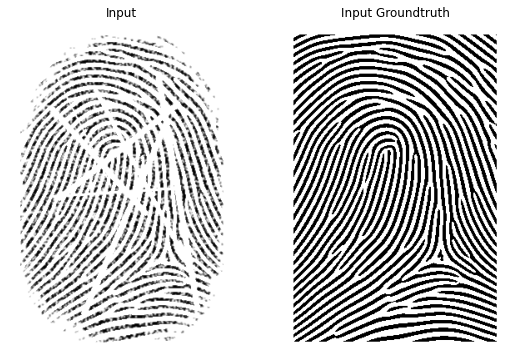

BOTH IMAGE HAVE SIZE:  (400, 275)


In [ ]:
# show 1 example of 10 images
img_a = cv2.imread(input_df.input[0], 0)
img_a_ground_truth = cv2.imread(input_df.input_target[0], 0)

sideplot(img_a, "Input", img_a_ground_truth, "Input Groundtruth")
print("BOTH IMAGE HAVE SIZE: ", img_a.shape)

# **1.Preprocessing for model training** 
- Resize & Thredsholding
- Groundtruth Bounding

## Resize and Thresholding 

In [ ]:
def resize_image(image, dim=(256, 320)):
  resized_img = cv2.resize(image, dim, interpolation = cv2.INTER_NEAREST)
  return resized_img

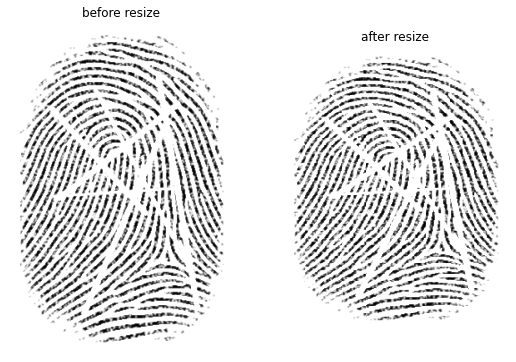

BEFORE RESIZE:  (400, 275)
AFTER RESIZE:  (320, 256)


In [ ]:
# show resize
img_a_resized = resize_image(img_a)
sideplot(img_a, "before resize", img_a_resized, "after resize")
print("BEFORE RESIZE: ", img_a.shape)
print("AFTER RESIZE: ", img_a_resized.shape)

In [ ]:
def threshold_image(image):
  _, binarized_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return binarized_img

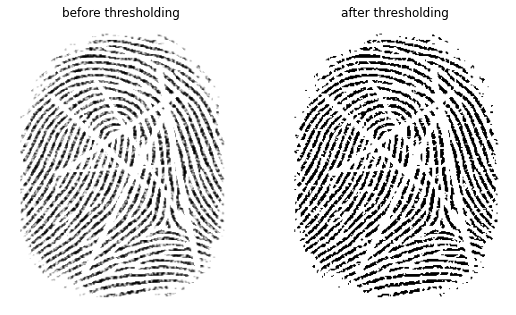

In [ ]:
# show threshold
img_a_binarized = threshold_image(img_a_resized)
sideplot(img_a_resized, "before thresholding", img_a_binarized, "after thresholding")
# สังเกตุว่าเข้มขึ้น

In [ ]:
def get_image_batch(paths, dim=(256, 320), thresholding=False):
  image_list = []
  for path in paths:
    img = cv2.imread(path, 0)
    resized_img = resize_image(img)
    if thresholding:
      binarized_img = threshold_image(resized_img)
      image_list.append(binarized_img / 255.0)
    else:
      image_list.append(resized_img / 255.0)

  return image_list

In [ ]:
input_image_list = get_image_batch(input_df.input, (256, 320), True)
input_ground_truth_image_list = get_image_batch(input_df.input_target, (256, 320), True)

## Groundtruth Bounding

In [ ]:
def pad_image(img, pad_t, pad_b, pad_l, pad_r):
  padded_img = cv2.copyMakeBorder(img, pad_t, pad_b, pad_l, pad_r, cv2.BORDER_REFLECT)
  return padded_img

In [ ]:
# note the images dim have to be exact the same
def bound_ground_truth_image(img, 
                             g_img, 
                             kernel_size = (1,1), 
                             dilation_kernel_size = (15,15), 
                             accepted_ratio = 0):
  padding = False
  half_kernel = math.ceil(kernel_size[0]/2)

  img_width = img.shape[0]
  img_height = img.shape[1]

  accepted_black_dot_count = math.ceil((kernel_size[0] * kernel_size[1]) * accepted_ratio)

  if (img_width % kernel_size[1] != 0 or img_height % kernel_size[0] != 0):
    padding = True
    pad_l = math.floor(kernel_size[0]/2)
    pad_r = math.ceil(kernel_size[0]/2)
    pad_t = math.floor(kernel_size[1]/2)
    pad_b = math.ceil(kernel_size[1]/2)
    img_width = img_width + pad_l + pad_r
    img_height = img_height + pad_t + pad_b
    
  dilation_filter = np.ones(dilation_kernel_size)
  white_filter = np.ones(kernel_size)
  black_filter = np.zeros(kernel_size)
  row_iteration = math.floor(img_width / kernel_size[0])
  col_iteration = math.floor(img_height / kernel_size[1])
  

  img = cv2.erode(img, dilation_filter, 1)
  img = cv2.dilate(img, dilation_filter, 1)

  if (padding):
    img = pad_image(img, pad_t, pad_b, pad_l, pad_r)
    g_img = pad_image(g_img, pad_t, pad_b, pad_l, pad_r)

  for i in range(row_iteration):
    for j in range(col_iteration):
      has_no_info = np.logical_and(img[i * kernel_size[0] : (i + 1) * kernel_size[0], j * kernel_size[1] : (j + 1) * kernel_size[1]], white_filter)
      false_count = sum([list(f).count(False) for f in has_no_info])
      if (false_count <= accepted_black_dot_count):
        g_img[i * kernel_size[0] : (i + 1) * kernel_size[0], j * kernel_size[1] : (j + 1) * kernel_size[1]] = black_filter
  
  if (padding):
    img = img[pad_l:(img_width - pad_r), pad_t: (img_height - pad_b)]
    g_img = g_img[pad_l:(img_width - pad_r), pad_t: (img_height - pad_b)]

  return g_img

In [ ]:
def ground_truth_bounding(nonoise_img, gt_img, kernel_size, dilation_kernel_size, dim):
  gt_img_t = np.copy(gt_img)

  # for bounded gt
  bounded_image = bound_ground_truth_image(nonoise_img, gt_img_t, kernel_size = kernel_size, dilation_kernel_size=dilation_kernel_size)
  bounded_resized_image = resize_image(bounded_image, dim)
  
  # for gt (resize only)
  gt_resized = resize_image(gt_img, dim)
  return gt_resized, bounded_resized_image

In [ ]:
img_a_nonoise = cv2.imread(input_df.input_nonoise[0], 0)

In [ ]:
KERNEL_SIZE = (1,1)
img_a_ground_truth_t = np.copy(img_a_ground_truth)
img_a_ground_truth_resized, img_a_bounded = ground_truth_bounding(img_a_nonoise, img_a_ground_truth_t, KERNEL_SIZE, (19,19), (256,320))

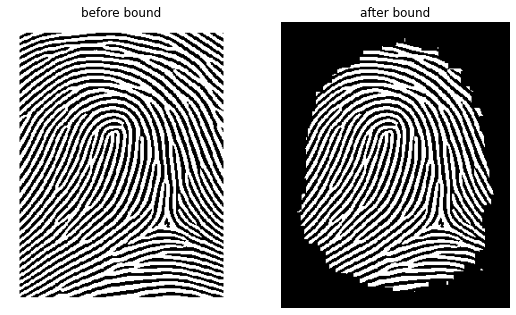

In [ ]:
sideplot(img_a_ground_truth_resized, "before bound", img_a_bounded, "after bound")

In [ ]:
input_bounded_ground_truth_image_list = get_image_batch(input_df.input_bounded_target, (256, 320), True)

# **2. The Loss Function of models**
We will visualize how each loss functions works.
consist of 3 loss function combine 
1. gradient loss
2. orientation loss 
3. reliability loss 

In [ ]:
img_a_binarized2 = np.copy(img_a_binarized)
img_a_listed = []
img_a_listed.append(img_a_binarized)
img_a_listed.append(img_a_binarized2)

## Gradient Loss

In [ ]:
def ridge_gradient_tf(images_tf):
  sobel_0 = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]).reshape(3,3,1,1)
  sobel_45 = np.array([[-1, -1, 0], [-1, 0, 1], [0, 1, 1]]).reshape(3,3,1,1)
  sobel_90 = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]).reshape(3,3,1,1)
  sobel_135 = np.array([[0, -1, -1], [1, 0, -1], [1, 1, 0]]).reshape(3,3,1,1)
  
  images_tf = tf.pad(images_tf, [[0,0], [1,1], [1,1], [0,0]], "REFLECT")  
  grads_0 = tf.nn.conv2d(images_tf, sobel_0, strides=[1, 1, 1, 1], padding='VALID')
  grads_45 = tf.nn.conv2d(images_tf, sobel_45, strides=[1, 1, 1, 1], padding='VALID')
  grads_90 = tf.nn.conv2d(images_tf, sobel_90, strides=[1, 1, 1, 1], padding='VALID')
  grads_135 = tf.nn.conv2d(images_tf, sobel_135, strides=[1, 1, 1, 1], padding='VALID')
  
  return grads_0, grads_45, grads_90, grads_135

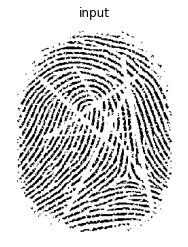

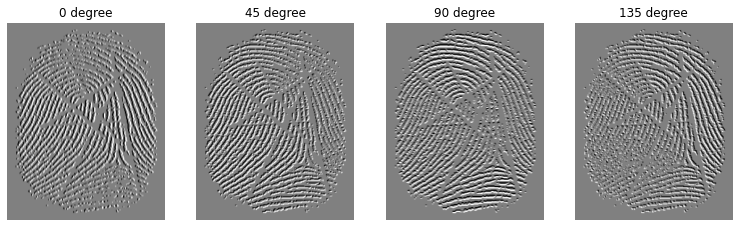

In [ ]:
#Test for Ridge Gradient TF

img_a_tf = tf.convert_to_tensor(get_image_batch(input_df.input[0:1], (256, 320), True))
img_a_tf = tf.reshape(img_a_tf, (-1, 320, 256, 1))
a,b,c,d = ridge_gradient_tf(img_a_tf)

plt.imshow(img_a_tf[0].numpy().reshape(320,256),'gray'), plt.title("input"), plt.axis('off'), plt.show() 

results = [] 
results.append(a[0].numpy().reshape(320,256))
results.append(b[0].numpy().reshape(320,256))
results.append(c[0].numpy().reshape(320,256))
results.append(d[0].numpy().reshape(320,256))

sideplot(results, ["0 degree", "45 degree", "90 degree", "135 degree"], (13,13))

## Orientation Loss & Reliability Loss

In [ ]:
GAUSS_BLOCK_KERNEL_SIZE = 7
GAUSS_BLOCK_SIGMA = 1
GAUSS_ORIENT_KERNEL_SIZE = 31
GAUSS_ORIENT_SIGMA = 5

GRAD_WEIGHT = 1
ORI_WEIGHT = 1.5
REL_WEIGHT = 1

GRAD_LOSS_SCALE = 10
ORI_LOSS_SCALE = 1e-1
REL_LOSS_SCALE = 1e-6

MAGIC_NUMBER_REL = 0.001

In [ ]:
def gaussian_kernel_smoothing(kernel_len = 21, sigma=3):
  kernel = np.zeros((kernel_len, kernel_len))
  # Dirac delta 
  kernel[kernel_len//2, kernel_len//2] = 1
  # Gaussian blur of dirac delta is the 2D gaussian mask filter
  return cv2.GaussianBlur(kernel, (kernel_len,kernel_len), sigmaX=sigma, sigmaY=sigma)

In [ ]:
def ridge_orientation_tf(images_tf):
    gb_k_size = GAUSS_BLOCK_KERNEL_SIZE
    go_k_size = GAUSS_ORIENT_KERNEL_SIZE
    pad_size = int((go_k_size - 1) / 2)

    # Gauss Block and Gauss Orient have to be smaller than this because of our input img is not as big as theirs
    gauss_block = np.array([gaussian_kernel_smoothing(gb_k_size, GAUSS_BLOCK_SIGMA)], dtype= np.float32)
    gauss_orient = np.array([gaussian_kernel_smoothing(go_k_size, GAUSS_ORIENT_SIGMA)], dtype= np.float32).reshape(go_k_size,go_k_size,1,1)

    sobel_0 = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    sobel_90 = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    gauss_gradient_x = cv2.filter2D(gauss_block.reshape(gb_k_size,gb_k_size), -1, sobel_0).reshape(gb_k_size,gb_k_size,1,1)
    gauss_gradient_y = cv2.filter2D(gauss_block.reshape(gb_k_size,gb_k_size), -1, sobel_90).reshape(gb_k_size,gb_k_size,1,1)
    
    images_tf = tf.pad(images_tf, [[0, 0], [3,3], [3, 3], [0, 0]], "REFLECT")
    gauss_img_x = tf.nn.conv2d(images_tf, gauss_gradient_x, strides=[1, 1, 1, 1], padding='VALID')
    gauss_img_y = tf.nn.conv2d(images_tf, gauss_gradient_y, strides=[1, 1, 1, 1], padding='VALID')

    gauss_img_xx = tf.math.pow(gauss_img_x, 2)
    gauss_img_xy = tf.math.multiply(gauss_img_x, gauss_img_y)
    gauss_img_yy = tf.math.pow(gauss_img_y, 2)

    gauss_img_xx = tf.pad(gauss_img_xx, [[0, 0], [pad_size,pad_size], [pad_size, pad_size], [0, 0]], "REFLECT")
    gauss_img_xy = tf.pad(gauss_img_xy, [[0, 0], [pad_size,pad_size], [pad_size, pad_size], [0, 0]], "REFLECT")
    gauss_img_yy = tf.pad(gauss_img_yy, [[0, 0], [pad_size,pad_size], [pad_size, pad_size], [0, 0]], "REFLECT")
    
    gauss_img_xx = tf.nn.conv2d(gauss_img_xx, gauss_orient, strides=[1, 1, 1, 1], padding='VALID')
    gauss_img_xy = tf.math.multiply(2, tf.nn.conv2d(gauss_img_xy, gauss_orient, strides=[1, 1, 1, 1], padding='VALID'))
    gauss_img_yy = tf.nn.conv2d(gauss_img_yy, gauss_orient, strides=[1, 1, 1, 1], padding='VALID')

    # Get orient img
    gauss_img_xx_square_diff_yy = tf.math.pow(tf.math.subtract(gauss_img_xx, gauss_img_yy), 2)
    gauss_img_xy_square = tf.math.pow(gauss_img_xy, 2)
    gauss_img_sum = tf.math.add(gauss_img_xx_square_diff_yy, gauss_img_xy_square)
    denom = tf.math.sqrt(gauss_img_sum)
    denom = tf.math.add(denom, 1**(-12))

    sin2theta = tf.math.divide(gauss_img_xy, denom)
    cos2theta = tf.math.divide(tf.math.subtract(gauss_img_xx, gauss_img_yy), denom)
    
    sin2theta2 = tf.math.divide(gauss_img_xy, denom)
    cos2theta2 = tf.math.divide(tf.math.subtract(gauss_img_xx, gauss_img_yy), denom)

    # Smooth double angle of orient img
    sin2theta = tf.pad(sin2theta, [[0, 0], [pad_size,pad_size], [pad_size, pad_size], [0, 0]], "REFLECT")
    cos2theta = tf.pad(cos2theta, [[0, 0], [pad_size,pad_size], [pad_size, pad_size], [0, 0]], "REFLECT")
    
    sin2theta = tf.nn.conv2d(sin2theta, gauss_orient, strides=[1, 1, 1, 1], padding='VALID')
    cos2theta = tf.nn.conv2d(cos2theta, gauss_orient, strides=[1, 1, 1, 1], padding='VALID')
    atan2_sin2cos2 = tf.math.atan2(sin2theta, cos2theta)
    atan2_sin2cos2_div2 = tf.math.divide(atan2_sin2cos2, 2)
    
    PI = tf.dtypes.cast(3.14159265, tf.float64)
    atan2_sin2cos2_div2 = tf.dtypes.cast(atan2_sin2cos2_div2, tf.float64)
    orient_imgs = tf.math.add(tf.math.divide(PI, 2), atan2_sin2cos2_div2)

    temp1 = tf.math.divide(tf.math.add(gauss_img_yy, gauss_img_xx), 2)
    temp2 = tf.math.subtract(gauss_img_xx, gauss_img_yy)
    temp3 = tf.math.multiply(temp2, cos2theta)
    temp4 = tf.math.divide(temp3, -2)
    temp5 = tf.math.divide(tf.math.multiply(gauss_img_xy, sin2theta), -2)
    
    Imin = tf.math.add_n([temp1, temp4, temp5])
    Imax = tf.math.subtract(tf.math.add(gauss_img_yy, gauss_img_xx), Imin)

    temp6 = tf.math.subtract(1, Imin)

    reliabilities = tf.math.divide(temp6, tf.math.add(Imax, MAGIC_NUMBER_REL) )

    return orient_imgs, reliabilities

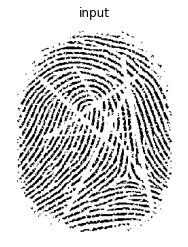

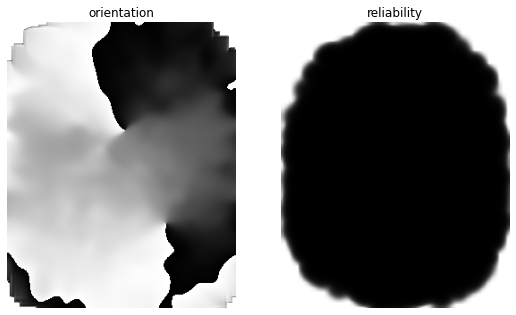

In [ ]:
# Unit Test for Ridge Orientation TF

ori, rel = ridge_orientation_tf(img_a_tf)

ori_results = [tf.reshape(ori, (320, 256)), tf.reshape(rel, (320, 256))]

plt.imshow(img_a_tf[0].numpy().reshape(320,256),'gray'), plt.title("input"), plt.axis('off'), plt.show() 
sideplot(ori_results, ["orientation", "reliability"], (9,9))


# **3. Auto Encoder Achitecture**
For one instances of input it'll be moving through auto encoder like this

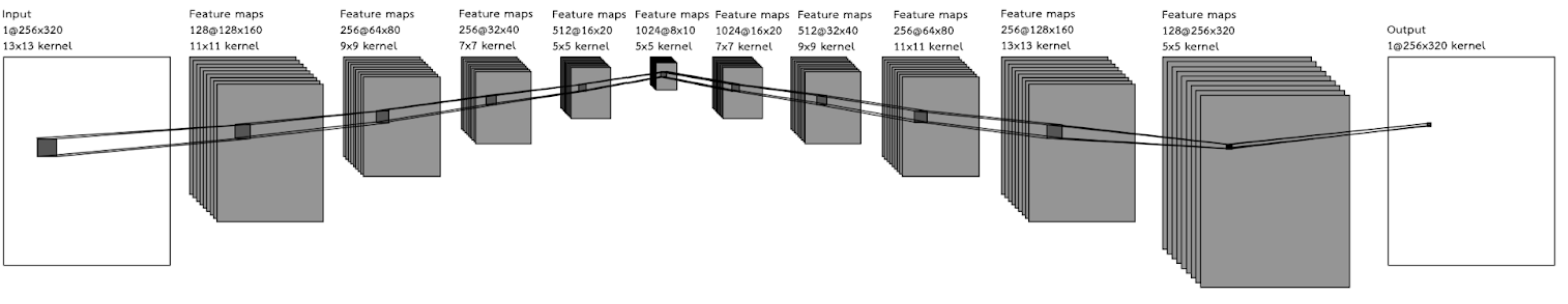
Note: each feature in each CNN layers also perfom BatchNorm() to increase training stability


In [ ]:
# Hyper Parameters
INPUT_SHAPE = (320, 256, 1)  # height, width, ch

E_LAYER_SIZES = [256, 128, 64, 32, 16, 8]
E_FILTER_SIZES = [13, 11, 9, 7, 5, 5]
E_NUM_FILTERS = [1, 128, 256, 256, 512, 1024]

G_LAYER_SIZES = [16, 32, 64, 128, 256]
G_FILTER_SIZES = [7, 9, 11, 13, 5]
G_NUM_FILTERS = [1024, 512, 256, 256, 128]

In [ ]:
def define_autoencoder(input_shape,
                       e_layer_sizes, 
                       e_filter_sizes, 
                       e_num_filters,
                       g_layer_sizes,
                       g_filter_sizes,
                       g_num_filters):
    
  e_iterations = len(e_layer_sizes)
  g_iterations = len(g_layer_sizes)

  # Encoder Section
  input_layer = Input(shape = input_shape)
  for i in range(e_iterations):
    if (i != 0):
        x = Conv2D(e_num_filters[i], kernel_size=(e_filter_sizes[i], e_filter_sizes[i]), strides=(2,2), padding='same')(x)
    else:
        x = Conv2D(e_num_filters[i], kernel_size=(e_filter_sizes[i], e_filter_sizes[i]), strides=(1,1), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

  
  # Ganerative Section
  for i in range(g_iterations):
    x = Conv2DTranspose(filters = g_num_filters[i], 
                        kernel_size = (g_filter_sizes[i], g_filter_sizes[i]), 
                        strides = (2, 2), 
                        padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
  
  x = Conv2DTranspose(1, kernel_size=(1, 1), padding='same')(x)
  output_layer = tf.keras.activations.sigmoid(x)

  model = Model(input_layer, output_layer)
  
  return model

In [ ]:
model = define_autoencoder(input_shape = INPUT_SHAPE,
                          e_layer_sizes = E_LAYER_SIZES,
                          e_filter_sizes = E_FILTER_SIZES,
                          e_num_filters = E_NUM_FILTERS,
                          g_layer_sizes = G_LAYER_SIZES,
                          g_filter_sizes = G_FILTER_SIZES,
                          g_num_filters = G_NUM_FILTERS)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 320, 256, 1)       170       
_________________________________________________________________
batch_normalization (BatchNo (None, 320, 256, 1)       4         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 320, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 128, 128)     15616     
_________________________________________________________________
batch_normalization_1 (Batch (None, 160, 128, 128)     512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 160, 128, 128)     0     

# Model's Prediction 

## Setup

In [ ]:
# Path to Model Weight and its optimizer state
MODEL_LOAD_PATH = '/content/drive/MyDrive/gae_weights/'
OPTIMIZER_LOAD_PATH = '/content/drive/MyDrive/gae_opt/'
model_weights_file_name = 'gae_id6_epoch9'
opt_weights_file_name = 'gae_id6_epoch9'

# Get Model's optimmizer state
opt_weights = np.load(OPTIMIZER_LOAD_PATH + opt_weights_file_name + '.npy', allow_pickle=True)
# Get Model Weights 
model_weights = np.load(MODEL_LOAD_PATH + model_weights_file_name + '.npy', allow_pickle=True)

In [ ]:
# This can actually can be any value because we gonna load the saved optimizar state into it anyway.
# Theese value below is twhat we used when training
WEIGHT_DECAY = 1e-4     
MOMENTUM     = 0.5        
LR           = 0.0002      # initial learning rate
EPSILON      = 1e-8

In [ ]:
# Optimizer initialization
optimizers = Adam(learning_rate=LR, beta_1=MOMENTUM, decay=WEIGHT_DECAY, epsilon=EPSILON)

grad_vars = model.trainable_weights
zero_grads = [tf.zeros_like(w) for w in grad_vars]
optimizers.apply_gradients(zip(zero_grads, grad_vars))

# Install Model's weights and optimizer state 
optimizers.set_weights(opt_weights)
model.set_weights(model_weights)

# Clear memory
del zero_grads
del grad_vars

## Prediction

In [ ]:
# Load subjects
subjects_tf = tf.convert_to_tensor(input_image_list)
subjects_tf = tf.reshape(subjects_tf, (-1, 320, 256, 1))

# predict
pred = model.predict(subjects_tf)

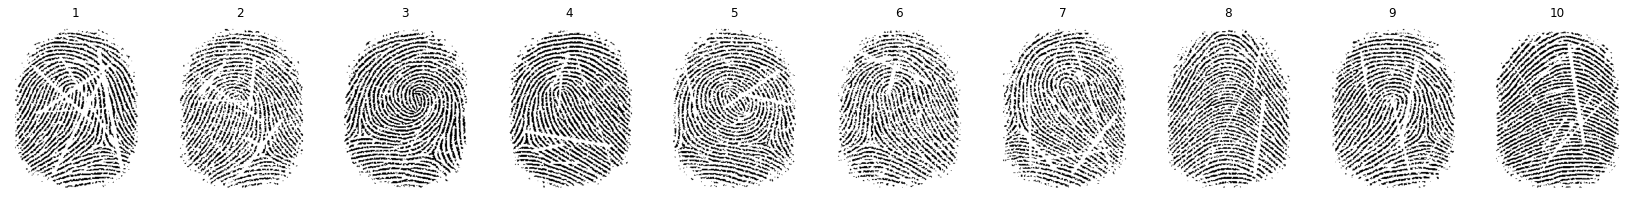

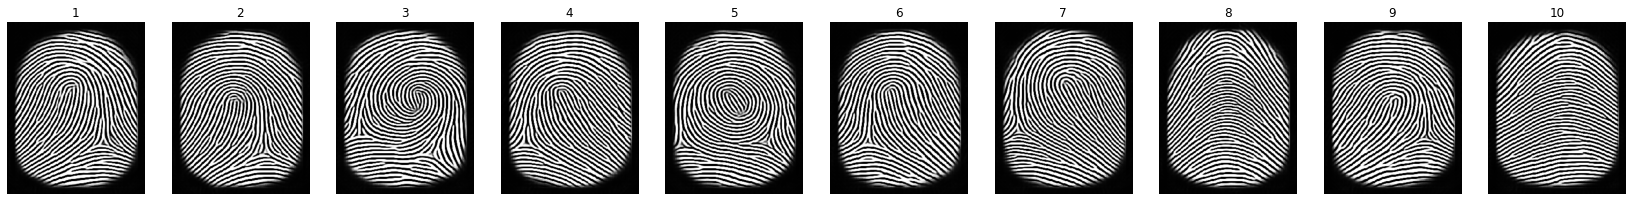

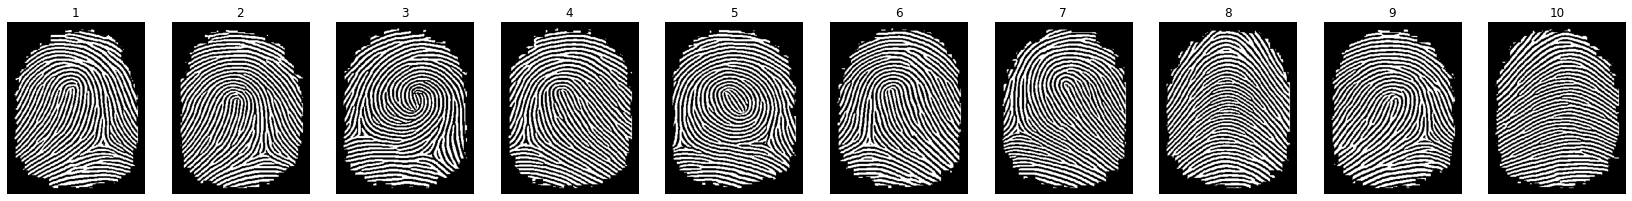

In [ ]:
sideplot(input_image_list, [i+1 for i in range(10)], (29,29))
sideplot([p.reshape(320, 256) for p in pred], [i+1 for i in range(10)], (29,29))
sideplot(input_bounded_ground_truth_image_list, [i+1 for i in range(10)], (29,29))

In [ ]:
#saving output
PATH_OUTPUT = "/content/drive/MyDrive/demo/output/"
for i, p in enumerate(pred):
  cv2.imwrite(PATH_OUTPUT + str(i+1) + '.png', p.reshape(320, 256)*1e3)

# **extra. NFIQ2.0 Preparation**
# The resolution of NFIQ2 have to be 500 dpi

In [ ]:
PATH_INPUT_500 = "/content/drive/MyDrive/demo/input_500dpi/"
PATH_OUTPUT_500 = "/content/drive/MyDrive/demo/output_500dpi/"

output_path_list = [f for f in glob.glob(PATH_OUTPUT + '*.png')]

In [ ]:
def set_dpi_image_batch(in_paths, index, out_path, dpi=500, resize=True, resize_dim=(256,320)):

  for i,path in enumerate(in_paths):
    img = Image.open(path)
    name = index[i]
    if (resize):
      img = img.resize(resize_dim, PIL.Image.NEAREST)
    img.save(out_path + name, dpi=(dpi, dpi))

In [ ]:
def extract_image_name(path_list):
  extracted_list = []
  for path in path_list:
    file_name = os.path.basename(path)
    extracted_list.append(file_name)
  return extracted_list

In [ ]:
index_list = extract_image_name(input_df.input)

In [ ]:
set_dpi_image_batch(input_df.input, index_list, PATH_INPUT_500)
set_dpi_image_batch(output_path_list, index_list, PATH_OUTPUT_500, resize=False)

# **4. Perform NFIQ2.0 Evaluation (OUTSIDE THIS NOTEBOOK)**

4.1 Download excutable file from [NFIQ2 GitHub Repo](https://github.com/usnistgov/NFIQ2) <br>
4.2 Type the following commands  <br>


> `$ nfiq2.exe -i <PATH_TO_IMAGES_DIRECTORY> -o <PATH_TO_OUTPUT_CSV_FILE>`


4.3 Data should be appeared in csv file provided in 4.2


# **5. Comparison between subjects and its prediction**

In [ ]:
PATH_INPUT_RESULT = "/content/drive/MyDrive/demo/demo_input_result.csv"
PATH_OUTPUT_RESULT = "/content/drive/MyDrive/demo/demo_output_result.csv"

In [ ]:
# Load saved CSV
nfiq_input_pd = pd.read_csv(PATH_INPUT_RESULT)
nfiq_output_pd = pd.read_csv(PATH_OUTPUT_RESULT)

In [ ]:
name_list_1 = extract_image_name(nfiq_input_pd.Filename)
name_list_2 = extract_image_name(nfiq_output_pd.Filename)

nfiq_input_pd['Name'] = name_list_1
nfiq_output_pd['Name'] = name_list_2

nfiq_pd = pd.concat([nfiq_input_pd['Name'], nfiq_input_pd['QualityScore'], nfiq_output_pd['QualityScore'], nfiq_output_pd['QualityScore'] - nfiq_input_pd['QualityScore']], axis=1, keys=['Name', 'QBefore', 'QAfter', 'Improvement'])

In [ ]:
nfiq_pd

,Name,QBefore,QAfter,Improvement
0,1.png,53,62,9
1,10.png,52,57,5
2,2.png,54,62,8
3,3.png,65,59,-6
4,4.png,46,54,8
5,5.png,45,69,24
6,6.png,43,62,19
7,7.png,59,53,-6
8,8.png,50,56,6
9,9.png,61,58,-3
